<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

**Importante: la entrega debe contener el notebook (.ipynb) y su HTML tras la completa ejecución secuencial (.html) donde se pueda ver el código y los resultados. Para exportar el notebook a HTML puedes hacerlo desde el menú File → Download as → HTML.**

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Ejemplo práctico: diseño de redes de transporte](#ej2)**: clustering y análisis.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong>
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [29]:
import random

import haversine as hs
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.
import smopy
import tqdm
import seaborn as sns
# import kruskal

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (5 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [4]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

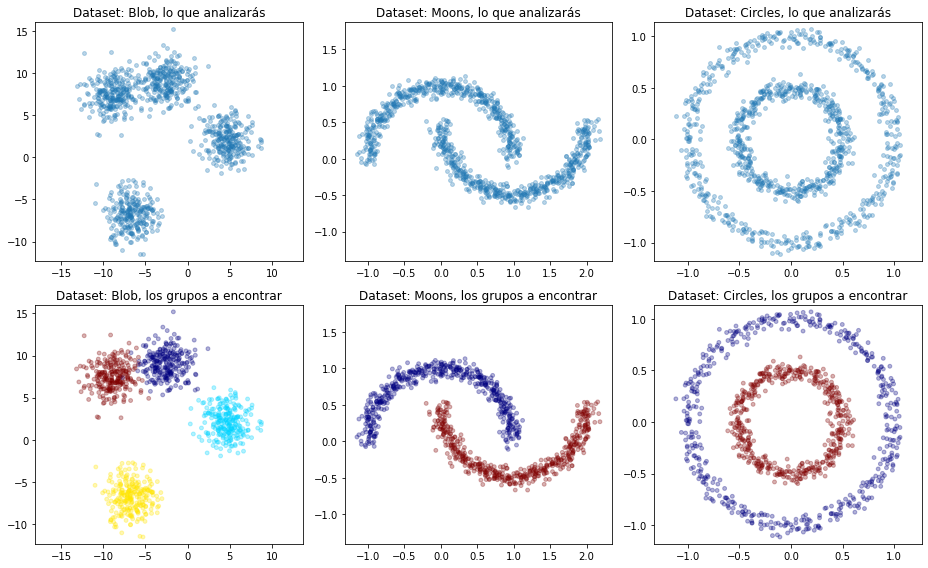

In [5]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3, cmap='jet')
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [6]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

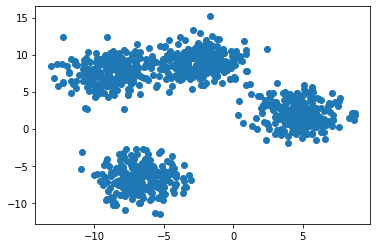

In [30]:
plt.scatter(X_blobs[:,0], X_blobs[:,1])
plt.show()

El primer paso es seleccionar el número de grupos, que viene determinado por el valor de k. 

Para seleccionar este valor se puede utilizar el método del Codo y seleccionaremos el valor de k en el cual aumentar el número de grupos, no reduce en gran medida el error.

Como vamos a probar diferentes valores de k, crearemos una función para calcular la inertia o SSE.

In [168]:
def kmeans_sse(k:int, X):
    random.seed(42)

    kmeans = cluster.KMeans(n_clusters=k, random_state=42)
    y_pred = kmeans.fit_predict(X)

    return kmeans.inertia_



def plot_sse(X):
    K_vals = np.linspace(1,10,10).astype(int)
    sse_values =[]

    for ki in K_vals:
        sse_score = kmeans_sse(ki, X)

        sse_values.append(sse_score)

    return plt.plot(K_vals, sse_values)

In [95]:
def plot_sse(X):
    K_vals = np.linspace(1,10,10).astype(int)
    sse_values =[]

    for ki in K_vals:
        sse_score = kmeans_sse(ki, X)

        sse_values.append(sse_score)

    return plt.plot(K_vals, sse_values)

C:\Users\Angel\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  f"KMeans is known to have a memory leak on Windows "


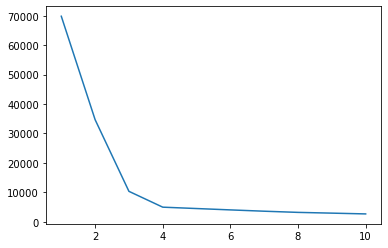

In [97]:
plot_sse(X_blobs)

In [72]:
K_vals = np.linspace(1,10,10).astype(int)
sse_values =[]

for ki in K_vals:
    sse_score = kmeans_sse(ki, X_blobs)

    sse_values.append(sse_score)

C:\Users\Angel\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  f"KMeans is known to have a memory leak on Windows "


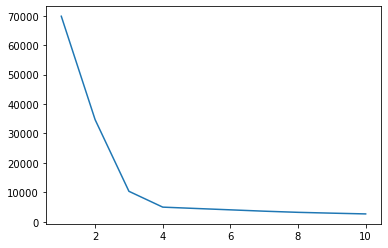

In [73]:
plt.plot(K_vals, sse_values)

En este plot se puede ver como el codo se produce en k=4. Por lo tanto, el mejor valor de k es el de 4 y el número de grupos que obtendremos en nuestros datos debería corresponderse con este número.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

In [23]:
X_blobs

array([[-8.38506716,  6.90927496],
       [-5.6922746 , -6.40124146],
       [-5.98630413, -6.75850097],
       ...,
       [ 3.12084061,  6.18498099],
       [-7.85484671, -7.17926368],
       [-9.7377966 ,  6.98876792]])

Como mencionaba anteriormente, la mejor elección de k siguiendo la regla del codo sería el valor de k=4. En la gráfica podemos ver cómo valores mayores a 4 apenas reducen el valor de SSE y el descenso en el valor de SSE se mantiene similar. 

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

In [105]:
def cluster_data(k, data):
    random.seed(42)

    kmeans = cluster.KMeans(n_clusters=k)
    y_pred = kmeans.fit_predict(data)

    sns.scatterplot(x=data[:,0], y=data[:,1], hue=y_pred)

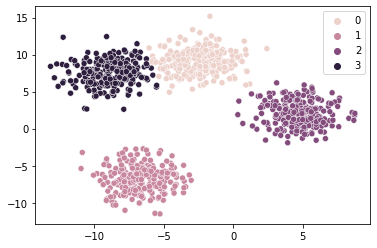

In [106]:
cluster_data(4, X_blobs)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado. 
</div>

Si nos fijamos en la figura obtenida con los 4 clusters, se asemeja mucho a la figura del ejemplo original. Esto es así porque el algoritmo se inicia con cuatro  puntos como centroides, pero en cada fase se asignan a cada centroide los puntos más próximos a este. 

Una vez se han asignado las instancias más próximas a este punto, se vuelve a definir el centroide de estos nuevos puntos y se repite el proceso. De manera que los centroides se van "moviendo" a las cuatro nubes de puntos diferenciadas hasta que volver a hacer este proceso no genera ningún cambio.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

C:\Users\Angel\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  f"KMeans is known to have a memory leak on Windows "


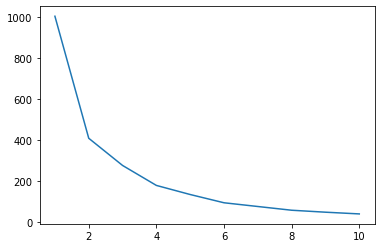

In [98]:
plot_sse(X_moons)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En esta gráfica, en cambio, se puede ver como k=2 es el valor más adecuado de k. Porque el codo se produce cuando k=2, después aumentar el número de clústers reduce en menor medida el valor de SSE. 

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

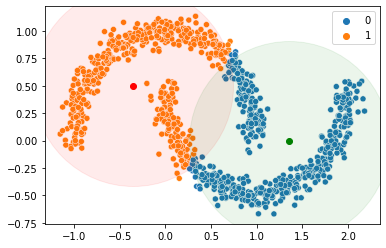

In [167]:
cluster_data(2, X_moons)
plt.scatter(x=-0.35, y=0.5, color='r')
plt.scatter(x=-0.35, y=0.5, color='r', s=40000, alpha=0.08)

plt.scatter(x=1.35, y=0, color='g')
plt.scatter(x=1.35, y=0, color='g', s=40000, alpha=0.08)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

El método de K-means no es apropiado para este tipo de datos. El método de k-means funciona cde forma radial, de manera que integra en un mismo grupo a todos los datos que tienen una distancia menor a un número dado. En este caso, este no es el método más adecuado porque los datos no se distribuyen de forma circular, sino siguiendo una forma de media luna, lo que provoca que parte de las instancias que deberían permanecer a una de las dos medias lunas.

De manera ilustrativa he dibujado la posición aproximada de los centroides y el radio en el que se encuentran los datos más cercanos. 

In [10]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

C:\Users\Angel\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  f"KMeans is known to have a memory leak on Windows "


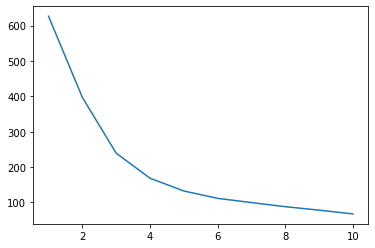

In [137]:
plot_sse(X_circles)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En este caso, el codo es más difícil de localizar, ya que no es tan claro como en los ejemplos anteriores. De hecho hay dos pequeños codos en k=3 y k=4. Una alternativa en este caso es emplear otra métrica distinta a la de SSE para tomar la decisión. En este caso, podemos emplear el valor de silhouette (Géron, 2019).

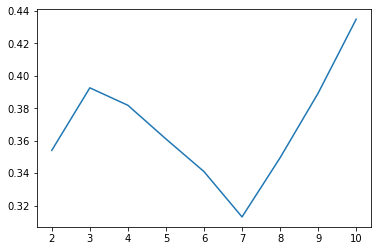

In [152]:
from sklearn.metrics import silhouette_score

k=2
kmeans = cluster.KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

score_list = []
for ki in np.linspace(2,10,9).astype(int):
    kmeans = cluster.KMeans(n_clusters=ki)
    y_pred = kmeans.fit_predict(X_circles)
    score_list.append(silhouette_score(X_circles, kmeans.labels_))
    
K_vals = np.linspace(2,10,9).astype(int)
    
plt.plot(K_vals, score_list)

El método de la Silueta nos ayuda a salir de dudas. Confirma que los valores de k=3 y k=4 son buenas soluciones, pero con esta visualización podemos ver como el valor de k=3 es ligeramente mejor.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

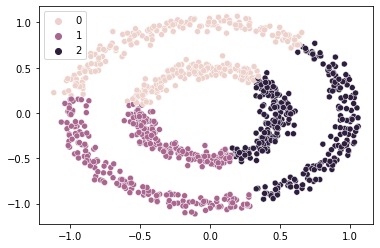

In [230]:
cluster_data(3, X_circles)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Como en el ejemplo anterior, en este caso los centroides no son capaces de separar correctamente los dos circulos. Los centroides acaban "dibujando" unas barreras entre las instancias, de manera que acaban separando los datos en tres partes iguales y separan los datos como si cortaran una pizza en tres cortes iguales. De alguna manera, el algoritmo separa los datos de la manera siguiente: 

Documentación consultada: https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html

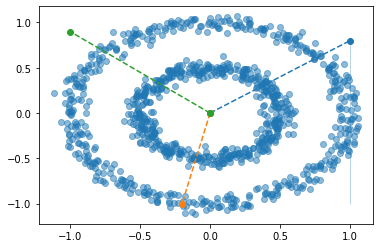

In [229]:
plt.scatter(X_circles[:,0], X_circles[:,1], alpha= 0.5)


x1 = np.array([0, 1])
x2 = np.array([0, -0.2])
x3 = np.array([0, -1])

y1 = np.array([0, 0.8])
y2 = np.array([0, -1])
y3 = np.array([0, 0.9])

plt.plot(x1, y1, 'o--')
plt.plot(x2, y2, 'o--')
plt.plot(x3, y3, 'o--')

### 1 b. Algoritmos basados en densidad: DBSCAN

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los dos grupos subyacentes.

Ésta es una visualización intuitiva de su funcionamiento: https://www.youtube.com/watch?v=RDZUdRSDOok

In [315]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

<AxesSubplot:>

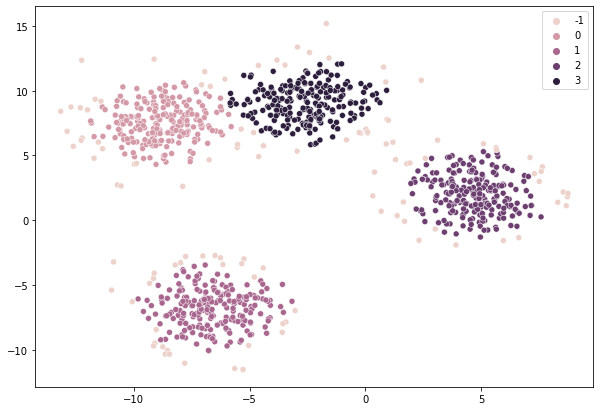

In [319]:
clustering = cluster.DBSCAN(eps=1.1, min_samples=20).fit(X_blobs)

plt.figure(figsize=(10,7))

sns.scatterplot(x=X_blobs[:,0], y=X_blobs[:,1], hue=clustering.labels_)

<AxesSubplot:>

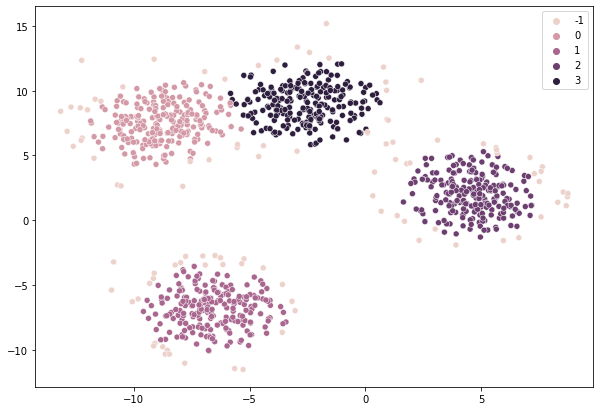

In [318]:
clustering = cluster.DBSCAN(eps=1.4, min_samples=40).fit(X_blobs)

plt.figure(figsize=(10,7))

sns.scatterplot(x=X_blobs[:,0], y=X_blobs[:,1], hue=clustering.labels_)

<AxesSubplot:>

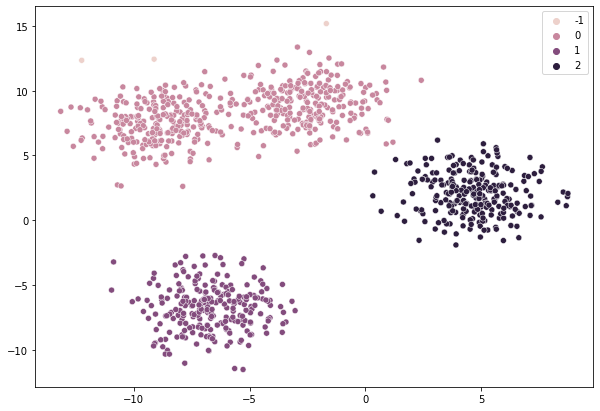

In [317]:
clustering = cluster.DBSCAN(eps=2, min_samples=15).fit(X_blobs)

plt.figure(figsize=(10,7))

sns.scatterplot(x=X_blobs[:,0], y=X_blobs[:,1], hue=clustering.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Después de probar con diferentes valores de epsilon (la distancia máxima a la que se pueden encontrar dos puntos para poder considerarse vecinos) y el el mínimo de valores que un punto tiene que tener a su lado para convertirse en "core point" he visto que:

Aunque es posible obtener los 4 clústers originales, vemos que para lograrlo obtenemos que muchos puntos no pertenecen a ningún grupo y son outliers. Aunque esto tiene una ventaja y es que nos permite identificar qué valores de los datos originales están más alejados de los clústers. Esta característica no la teníamos con k-means. Que se trata de un algoritmo exhaustivo y clasifica a todos los puntos en un grupo aunque en realidad no pertenezcan a ninguno.

Por otro lado, si queremos obtener unos resultados más exhaustivos y reducir el número de outliers, no nos queda otra que agrupar en un mismo clúster los dos grupos que están más solapados.

In [306]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

<AxesSubplot:>

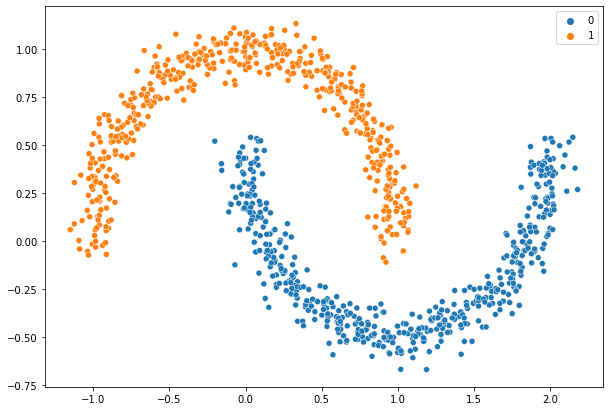

In [328]:
clustering = cluster.DBSCAN(eps=0.2, min_samples=30).fit(X_moons)

plt.figure(figsize=(10,7))

sns.scatterplot(x=X_moons[:,0], y=X_moons[:,1], hue=clustering.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

A diferencia de lo que pasaba con KMeans, hemos podido agrupar los puntos que pertenecen a los dos clústers de manera intuitiva. Este método es especialmente eficaz en caso en los que queremos agrlutinar puntos en base a su proximidad y que siguen formas menos convencionales.

In [329]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

<AxesSubplot:>

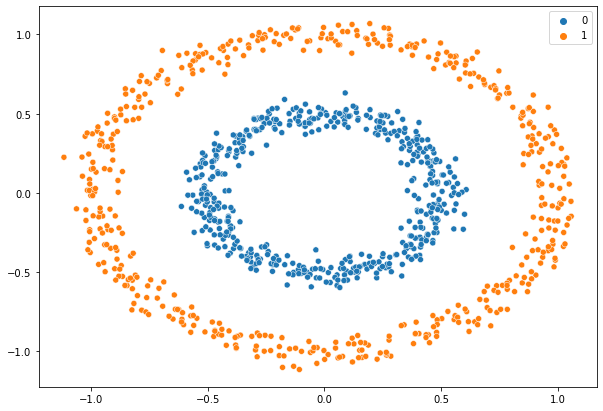

In [333]:
clustering = cluster.DBSCAN(eps=0.1, min_samples=5).fit(X)

plt.figure(figsize=(10,7))

sns.scatterplot(x=X[:,0], y=X[:,1], hue=clustering.labels_)

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Como en el caso anterior, este algoritmo rinde mejor que el KMeans. Ya que agrupa los puntos por proximidad entre ellos y no por proximidad a un centro como sucede con KMeans y que ofrece como resultados clústers que no se corresponden con lo que vemos con nuestros ojos.

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [19]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

In [22]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

In [24]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

<a id="ej2"></a>

## 2. Ejemplo práctico: diseño de redes de transporte (5 puntos)

Imaginemos que un famoso magnate llamado Melon Mask ha culminado su nuevo invento: el hypermegaminiloop. Que revoluciona el transporte urbano, pero de momento es muy muy caro.

El alcalde de Nueva York se ha enterado de su existencia y quiere ser un *early adopter* del proyecto y complementar (que no sustituir) su red de transporte. Para ello se dispone de datos de la [demanda de Uber](https://data.world/data-society/uber-pickups-in-nyc) que con este nuevo método se pretende cubrir.

Se provee de un subconjunto del dato representativo pero de menor tamaño para evitar que su procesado conlleve tiempos de ejecución muy grandes.

In [335]:
df = pd.read_csv('uber_sample.csv')
df.head(3)

,Date/Time,Lat,Lon,Base
0,9/16/2014 5:37:00,40.7651,-73.9615,B02764
1,9/21/2014 12:12:00,40.7249,-73.9947,B02764
2,9/22/2014 12:50:00,40.7720,-73.9590,B02598


Visualizamos los datos para ver donde hay mayor concentración de peticiones y facilitar el posterior análisis de los datos. ¿Puedes localizar *Central Park*?

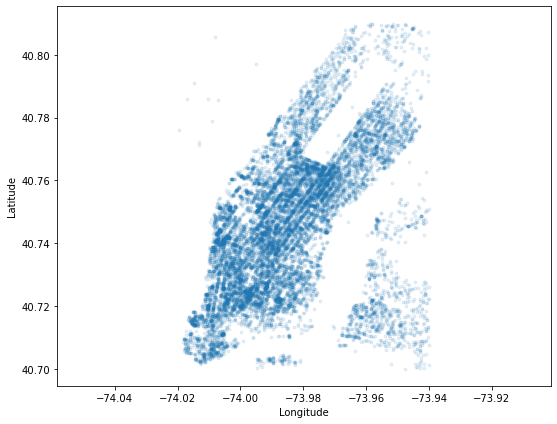

In [336]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(df['Lon'], df['Lat'], s=8, alpha=.1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.axis('equal')
plt.tight_layout()

### 2 a. Localización de las paradas: clustering

La primera parte del diseño de la red de transporte es situar las futuras paradas. Para ello tendrás que identificar entre 100 y 200 lugares del mapa (aproximación aportada por el departamento de transporte de la ciudad) con alta concentración de demanda.

Puedes elegir cualquier algoritmo de clustering para este cometido, pero recuerda que tendrás que justificar la respuesta para la propuesta de proyecto.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
elige y aplica una técnica de clustering para encontrar entre 100 y 200 grupos de puntos.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los grupos encontrados dotando de color a los puntos en base al cluster al que pertenecen. Puedes utilizar el colormap 'tab20' para tener una paleta de color discreta y amplia que permita visualizar mejor los resultados.
</div>

146


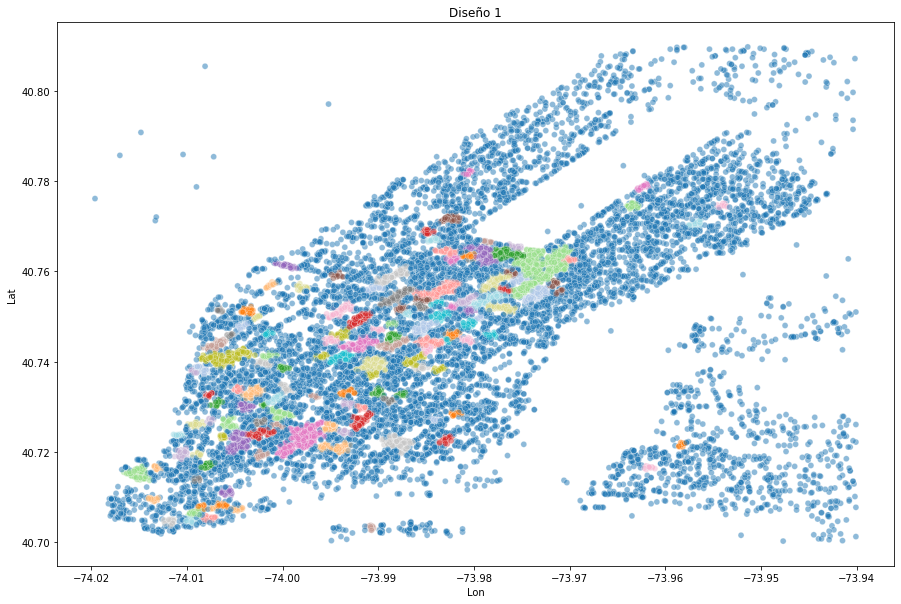

In [454]:
dat =df[['Lon', 'Lat']]
clustering = cluster.DBSCAN(eps=0.0006, min_samples=15).fit(dat)
print(len(set(clustering.labels_)))


plt.figure(figsize=(15,10))

plt.title('Diseño 1')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], palette='tab20', alpha=.5, hue=clustering.labels_)

plt.legend([],[], frameon=False)
plt.show()

195


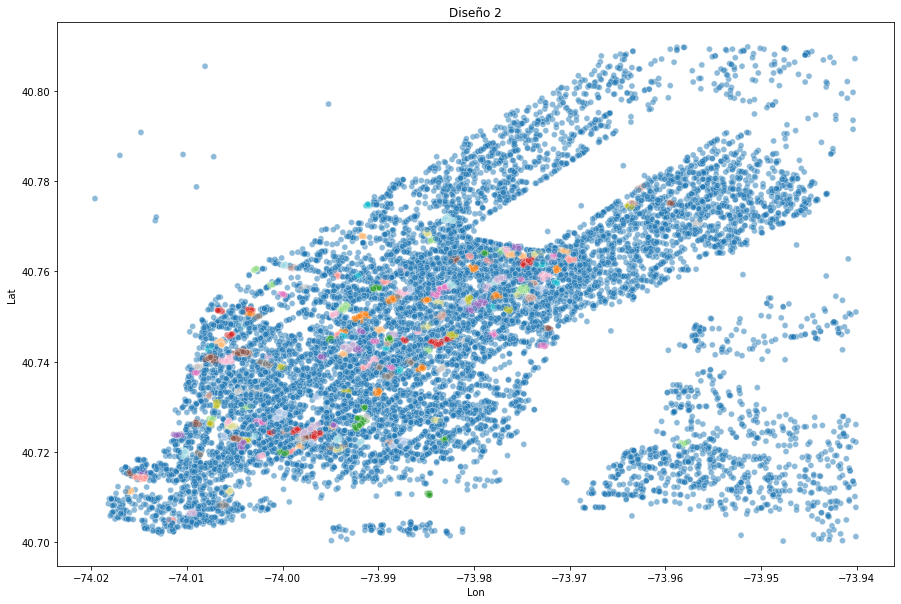

In [573]:
dat =df[['Lon', 'Lat']]

clustering = cluster.DBSCAN(eps=0.00035, min_samples=10).fit(dat)
print(len(set(clustering.labels_)))


plt.figure(figsize=(15,10))

plt.title('Diseño 2')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], palette='tab20', alpha=.5, hue=clustering.labels_)
plt.legend([],[], frameon=False)
plt.show()

191


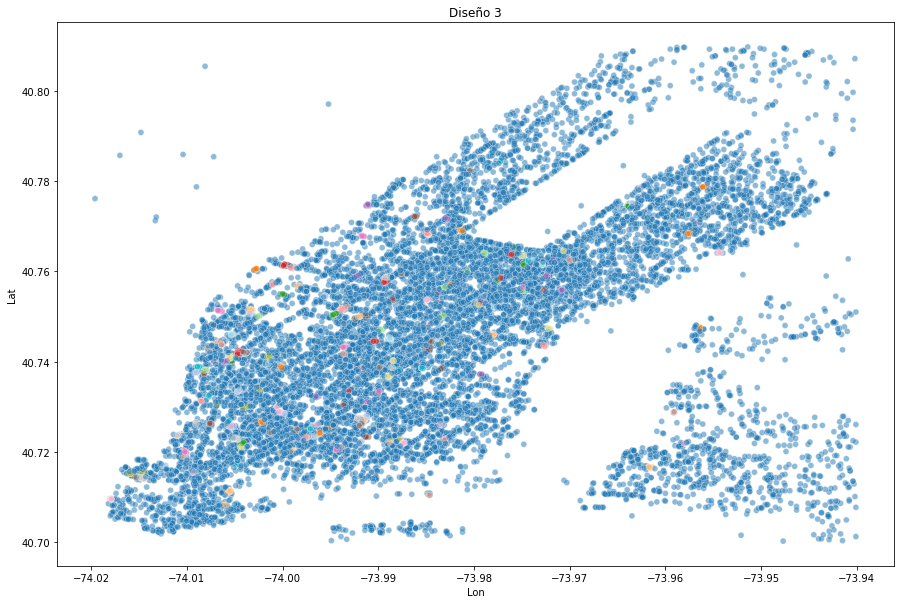

In [456]:
dat =df[['Lon', 'Lat']]
clustering = cluster.DBSCAN(eps=0.00021, min_samples=7).fit(dat)
print(len(set(clustering.labels_)))


plt.figure(figsize=(15,10))

plt.title('Diseño 3')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], palette='tab20', alpha=.5, hue=clustering.labels_)

plt.legend([],[], frameon=False)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    De cara a la redacción de la propuesta de proyecto, ¿por qué has elegido este método de agrupamiento?
</div>

En este ejercicio se pedía encontrar zonas con alta densidad de usuarios que demandan transporte público. Para eso, he utilizado el algoritmo de DBSCAN porque permite encontrar zonas con alta densidad o mucha concentración de datos. Además, los parámetros de epsilon y mínimo número de muestras me han permitido buscar zonas con una concentración de puntos relevante para esta situación.

En este caso, pretendemos suplir la demanda de Uber con transporte público. Las personas que utilizan Uber están acostumbradas a viajar solas y a recibir el servicio puerta a puerta. Por lo tanto, están acostumbradas a caminar poco y querrán que la parada este a poca distancia. Por esa razón, era necesario utilizar un algoritmo que fuera capaz de agrupar puntos que estuvieran en un rango de distancia pequeño y que permitiera escoger el número de puntos mínimo en esa distancia para que se formara un clúster. Teniendo en cuenta las características de Uber, he ideado tres posibles diseños.

Aunque los tres diseños cumplen las características formales del problema, el primer diseño contenía clústers  demasiado grandes y no tiene en cuenta que este tipo de cliente preferirá viajar en entornos con menos gente. El segundo reduce este problema y los grupos son relativamente pequeños, de manera que en las paradas no había tanta densidad de gente. Por último, en el tercer diseño los puntos son excesivamente pequeños y la rentabilidad del transporte puede quedar afectada. De manera que a mi parecer, el segundo diseño es el más apropiado para este problema porque minimiza los problemas de los otros dos diseños. En una situación real se tendrían que considerar informes económicos que consideren la viabilidad de los tres diseños. Por otro lado, puede haber un sesgo de supervivencia en los datos. Puede que algunos usuarios que no usan Uber, estuvieran interesados en usar este transporte. Por ejemplo, personas preocupadas por el medio ambiente o con rentas más bajas pueden tener más reticiencias a usar Uber. Por otro lado, no se puede pedir un Uber en Central Park, pero quizá si se podría pedir un hypermegaminiloop. La gente no pide un Uber en Central Park, no porque no quiera, sino poque no puede. Complementar estos datos con más información y otras fuentes de datos ayudarían a decidir el número de paradas y el lugar ideal para colocarlas.

### 2 b. Análisis de grupos y preparación de datos

Antes de continuar con el diseño de la red de transporte hay que validar que los grupos tienen sentido.

Lo primero es estimar la densidad de cada grupo encontrado:

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
calcula para cada cluster su área:
    <br/>
    1. Puedes simplificarla de la siguiente manera: (lat_max - lat_min) * (lon_max - lon_min), cuidado con los valores negativos, de los puntos que pertenecen al grupo.
    <br/>
    2. También calcula el número de puntos que pertenecen a cada grupo.
    <br/>
    3. Calcula el siguiente ratio: número de puntos (2) por área cubierta (1) de cada cluster.
    <br/>
    Por último, visualiza para cada cluster el resultado de este cálculo (3) en un diagrama de barras.
</div>

In [564]:
dat =df[['Lat', 'Lon']]

clustering = cluster.DBSCAN(eps=0.00035, min_samples=10).fit(dat)
dat.insert(2, 'Labels', clustering.labels_)

dat.head()

,Lat,Lon,Labels
0,40.7651,-73.9615,-1
1,40.7249,-73.9947,-1
2,40.7720,-73.9590,-1
3,40.7259,-73.9905,-1
4,40.7561,-73.9731,0


In [565]:
# el label -1 no corresponde a ningún clúster, sino a datos no asignados
# y será eliminado del dataset

clus = dat.groupby('Labels').agg([min, max, 'count']).reset_index().iloc[1:]
clus.head(3)

Labels      Lat                     Lon               
              min      max count      min      max count
1      0  40.7554  40.7564    24 -73.9733 -73.9725    24
2      1  40.7505  40.7511    20 -74.0039 -74.0031    20
3      2  40.7253  40.7257    11 -73.9952 -73.9947    11

In [566]:
area = (clus['Lat']['max']-clus['Lat']['min'])*(clus['Lon']['max']+abs(clus['Lon']['min']))
area

1      8.000000e-07
2      4.800000e-07
3      2.000000e-07
4      4.800000e-07
5      2.210000e-06
           ...     
190    1.000000e-07
191    1.200000e-07
192    3.000000e-07
193    1.200000e-07
194    2.000000e-07
Length: 194, dtype: float64

In [567]:
ratio_area = area/clus['Lon']['count']
ratio_area

1      3.333333e-08
2      2.400000e-08
3      1.818182e-08
4      1.846154e-08
5      4.169811e-08
           ...     
190    1.000000e-08
191    1.500000e-08
192    2.727273e-08
193    1.200000e-08
194    1.818182e-08
Length: 194, dtype: float64

In [568]:
clus.insert(7, 'area', area)

In [569]:
clus.insert(8, 'ratio_area', ratio_area)

clus.head(10)

Labels      Lat                     Lon                         area  \
               min      max count      min      max count                 
1       0  40.7554  40.7564    24 -73.9733 -73.9725    24  8.000000e-07   
2       1  40.7505  40.7511    20 -74.0039 -74.0031    20  4.800000e-07   
3       2  40.7253  40.7257    11 -73.9952 -73.9947    11  2.000000e-07   
4       3  40.7445  40.7457    26 -73.9890 -73.9886    26  4.800000e-07   
5       4  40.7552  40.7569    53 -73.9757 -73.9744    53  2.210000e-06   
6       5  40.7613  40.7632    63 -73.9752 -73.9736    63  3.040000e-06   
7       6  40.7624  40.7630    15 -73.9704 -73.9695    15  5.400000e-07   
8       7  40.7209  40.7223    44 -74.0047 -74.0039    44  1.120000e-06   
9       8  40.7238  40.7263    62 -73.9984 -73.9961    62  5.750000e-06   
10      9  40.7413  40.7428    76 -74.0052 -74.0034    76  2.700000e-06   

      ratio_area  
                  
1   3.333333e-08  
2   2.400000e-08  
3   1.818182e-08  
4   1.846154e-08  
5   4.169811e-08  
6   4.825397e-08  
7   3.600000e-08  
8   2.545455e-08  
9   9.274194e-08  
10  3.552632e-08

In [570]:
clus.sort_values(by='ratio_area')

Labels      Lat                     Lon                         area  \
                min      max count      min      max count                 
132    131  40.7375  40.7376    11 -74.0095 -74.0089    11  6.000000e-08   
45      44  40.7603  40.7606    11 -74.0030 -74.0027    11  9.000000e-08   
83      82  40.7677  40.7680    10 -73.9918 -73.9915    10  9.000000e-08   
190    189  40.7751  40.7753    10 -73.9596 -73.9591    10  1.000000e-07   
150    149  40.7399  40.7401    10 -74.0074 -74.0069    10  1.000000e-07   
..     ...      ...      ...   ...      ...      ...   ...           ...   
41      40  40.7280  40.7290    30 -74.0008 -73.9994    30  1.400000e-06   
6        5  40.7613  40.7632    63 -73.9752 -73.9736    63  3.040000e-06   
61      60  40.7215  40.7229    35 -73.9881 -73.9868    35  1.820000e-06   
32      31  40.7545  40.7568    65 -73.9845 -73.9827    65  4.140000e-06   
9        8  40.7238  40.7263    62 -73.9984 -73.9961    62  5.750000e-06   

       ratio_area  
                   
132  5.454545e-09  
45   8.181818e-09  
83   9.000000e-09  
190  1.000000e-08  
150  1.000000e-08  
..            ...  
41   4.666667e-08  
6    4.825397e-08  
61   5.200000e-08  
32   6.369231e-08  
9    9.274194e-08  

[194 rows x 9 columns]

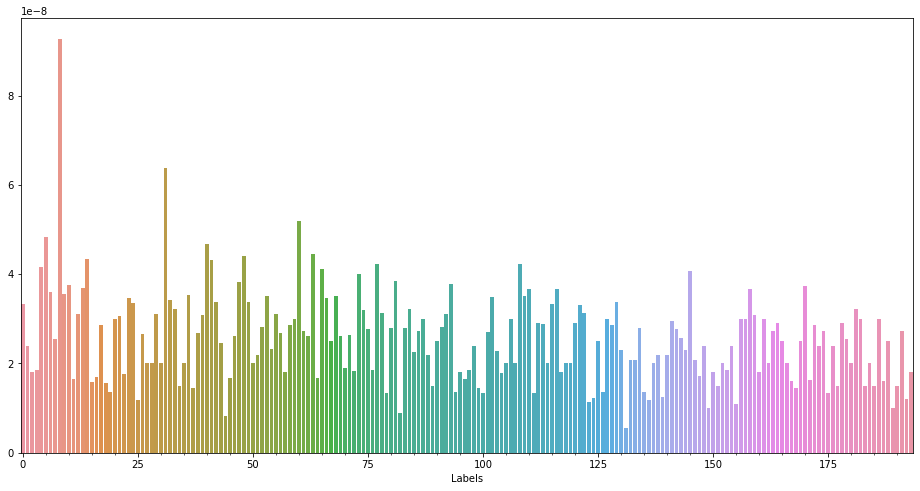

In [571]:
import matplotlib.ticker as ticker

plt.figure(figsize=(16,8))
ax = sns.barplot(x=clus['Labels'], y=ratio_area)

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    ¿Observas alguna situación sospechosa? Analízala y, si es necesario, limpia el dato para las siguientes fases.
</div>

In [578]:
def check_label(n):
    check_number = []
    for i in clustering.labels_:
        if i != n:
            i = -1
        check_number.append(i)
    return check_number            

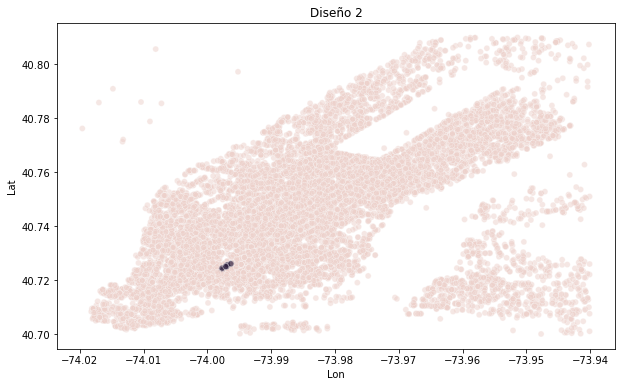

In [583]:
plt.figure(figsize=(10,6))

plt.title('Diseño 2')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], alpha=.5, hue=check_label(8))
plt.legend([],[], frameon=False)
plt.show()

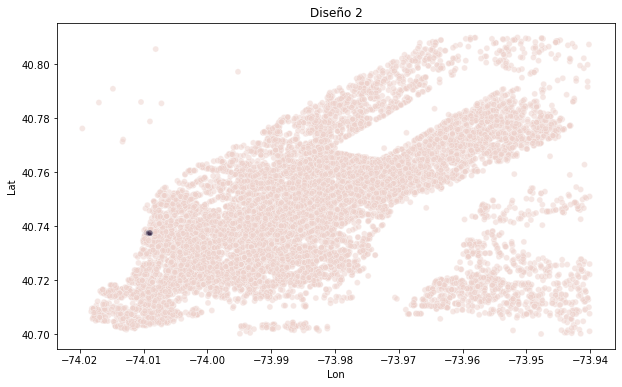

In [584]:
plt.figure(figsize=(10,6))

plt.title('Diseño 2')
sns.scatterplot(x=dat['Lon'], y=dat['Lat'], alpha=.5, hue=check_label(131))
plt.legend([],[], frameon=False)
plt.show()

Vemos que hay un outlier en la label 8. Mirando en detalle vemos como la zona está bastante desperdigada y el espacio del clúster es bastante amplio. Aún así, el área en la que están desperdigado los puntos es bastante pequeña y quien quiera coger este transporte tendrá que caminar unos pocos metros más que en otras paradas. El área sigue siendo pequeña. Por eso, no me planteo eliminar este punto.

### 2 c. Diseño de la red de transporte

Debido a que la tecnología es muy nueva y cara, tenemos el mandato de hacer un diseño que minimice la extensión de la red tratando de dar cobertura al mayor número de peticiones posibles.

Para ello se pueden usar distintas estrategias. Entre ellas la familia *MST* o [*Minimum Spanning Tree*](https://en.wikipedia.org/wiki/Minimum_spanning_tree), con algoritmos como el de [*Kruskal*](https://en.wikipedia.org/wiki/Kruskal%27s_algorithm) o *Prim*. El algoritmo de *Kruskal* tiene la ventaja de ser muy rápido por ser *greedy* o voraz (subóptimo) y, además, evita ciclos. Un beneficio extra, ya que en nuestro caso establecería enlaces redundantes, los cuales queremos evitar por el elevado coste.

Los pasos son los siguientes:
1. Preparar los datos para el grafo.
2. Aplicar el algoritmo de Kruskal.
3. Analizar los resultados y decidir el diseño final de la red.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un dataframe en el que haya una fila por cluster y ésta contenga: <b>id</b> del cluster (numérico), <b>latitud</b> y <b>longitud</b> (representativa del cluster), y <b>número de puntos</b> pertenecientes al cluster.
</div>

Para crear el grafo no dirigido (si 1 está conectado con 2 se asume la dirección inversa) a partir del cual el algoritmo de *Kruskal* seleccionará los enlaces es necesario indicarle las posibles aristas del grafo.

Para crear el grafo simplemente hay que instanciar la clase `Graph` del módulo *kruskal* que hemos modificado a partir de [aquí](https://www.pythonpool.com/kruskals-algorithm-python/). Indicando en el parámetro `vertex` de su constructor el id más alto de cluster +1. Posteriormente se pueden añadir aristas al grafo indicando primero los dos ids de clusters que une el tramo y por último su peso que viene indicado por la definición de *weight* más adelante.

Por último, se calcula el resultado de *Kruskal* sobre el grafo haciendo una llamada al método `kruskal`, que también dispone de un parámetro `max_links` si sólo deseamos que se generen tantos tramos como se indiquen (útil más adelante).

Un ejemplo concreto sería el siguiente:

```
g = kruskal.Graph(vertex=5)
g.add_edge(0, 1, 8)
...
g.add_edge(3, 4, 7)
g.kruskal()
```

Debido al alto coste es necesario justificar la construcción de cada tramo del *hypermegaminiloop*, por lo que vamos a emplear una métrica que pese (*weight*) cada tramo (unión entre 2 clusters cualquiera $i$ y $j$):

$$weight(i, j) = -\frac{n_i+n_j}{dist(i, j)}$$

Donde:
 - $n_i$ es el número de puntos del cluster $i$, de la misma manera $n_j$ es el número de puntos del cluster $j$.
 - $dist(i, j)$ es la distancia geográfica en km entre el centro del cluster $i$ y el cluster $j$.
 
La distancia geográfica entre 2 puntos cualesquiera no es la distancia euclídea, puesto que la tierra tiene curvatura. Para ello puedes usar el módulo [haversine](https://pypi.org/project/haversine/) (ya importado como *hs* al inicio de la PEC).

Por último, resaltar que el peso final es negativo porque el algoritmo de *Kruskal* ve este peso como un coste que trata de minimizar. Por nuestra parte, deseamos incentivar que a medida que más alto sea el ratio descrito más atractivo le sea a *Kruskal*, por eso se hace negativo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un grafo siguiendo el código de ejemplo en el que aparezcan todos los pares de clusters posibles (no hace falta repetir los pares porque se trata de un grafo no dirigido donde A-B también equivale a B-A), donde el peso (último parámetro del método add_edge) se calcule tal y como se describe en la fórmula de weight.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
aplica el algoritmo de Kruskal llamando al método kruskal del grafo variando el número de ejes en función de tu criterio (compromiso entre extensión y coste).
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los centros de los clusters indicando su importancia (por ejemplo incrementando su diámetro o cambiar su color en función del número de puntos que contiene) y sus enlaces indicando también su importancia (mediante su grosor o transparencia) producidos por la salida de Kruskal.
</div>

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
    Además del método de Kruskal ¿se te ocurren o conoces otros métodos que podrían mejorar la solución? Descríbelo brevemente.
</div>

### 2 d. [OPCIONAL] Visualización sobre el mapa

Para observar cómo queda el proyecto sobre el plano se puede usar la librería [smopy](https://github.com/rossant/smopy) que se apoya en [OpenStreetMap](https://www.openstreetmap.org/).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza los enlaces indicando su importancia (mediante su grosor o transparencia) producidos por la salida de Kruskal sobre el plano.
</div>